# Demonstrating NumPy:

Here we implement the algorithm described in *Exact Stochastic Simulation of Coupled Chemical Reactions* by Danlel T. Gillespie.
A copy can be found online [here](https://www.caam.rice.edu/~cox/gillespie.pdf).

For testing our algorithm we shall consider the [exponential decay](https://en.wikipedia.org/wiki/Exponential_decay) example,
as such processes are ubiquitous. Additionally we can numerically solve many features of interest in this system, and compare those
features to our simulation results.

For a review of what $e$ is, see this [video](https://www.youtube.com/watch?v=m2MIpDrF7Es).

In [1]:
import numpy as np
# For a discussion of random sampling see:
# https://numpy.org/doc/stable/reference/random/index.html 
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
%matplotlib inline

## Exponential Decay

The first thing we do is implement an exponential decay function:

In [2]:
def exponential_decay(X, c, t):
    """
    X: initial number of a species
    c: exponential decay constant
    t: a give time
    """
    return X * np.exp(-c * t)

# Declare a time range for X to decay over:
time_range = np.linspace(0, 10, 1000)
print(time_range.shape)

(1000,)


In [4]:
# time_range

Now calculate the expected value of X at each time point:

In [9]:
x_decay = exponential_decay(1000, 0.5, time_range)
print(x_decay.shape)

(1000,)


In [10]:
# x_decay

We can plot the results of our new function:

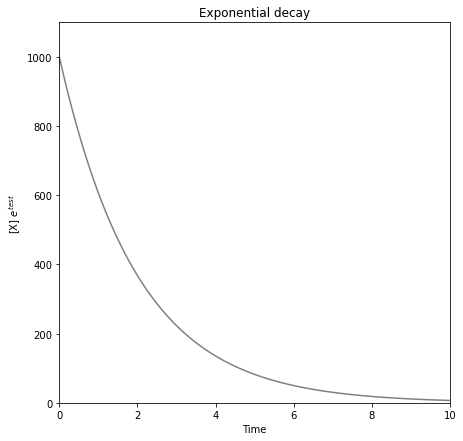

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(ylim=(0, 1100), xlim=(0, time_range[-1]), 
       xlabel="Time", ylabel="[X] $e^{test}$",
       title='Exponential decay')
ax.plot(time_range, x_decay, 'k', alpha=0.5, linewidth=1.5);  # Semi-colon prevents some misc text output.

As hinted, there are some other features we can calculate for exponential decay.
Here is the root mean square of the deviation:

$$
\Delta(t) = [X_0 e^{-ct}(1 - e^{-ct})]^{\frac{1}{2}}
$$

In [17]:
# with the same variable descriptions as in the exp function.
# use more () instead of [], python treats those differently.
def rms_exp(X, c, t):
    return (X * np.exp(-c * t) * (1 - np.exp(-c * t)))**(0.5)

In [21]:
rms.shape

(1000,)

In [20]:
time_range.shape

(1000,)

In [22]:
upper.shape

(1000,)

In [23]:
lower.shape

(1000,)

In [25]:
lower

array([1000.        ,  992.77869326,  986.89972061,  981.26560068,
        975.77132033,  970.37595443,  965.05836772,  959.80590408,
        954.6102416 ,  949.46553959,  944.36749578,  939.31282008,
        934.29891982,  929.32370103,  924.38543715,  919.4826794 ,
        914.61419346,  909.77891369,  904.9759093 ,  900.20435882,
        895.46353048,  890.75276701,  886.07147354,  881.41910806,
        876.79517357,  872.19921183,  867.63079807,  863.08953674,
        858.57505781,  854.0870138 ,  849.62507713,  845.18893798,
        840.77830236,  836.39289048,  832.03243538,  827.69668164,
        823.38538438,  819.09830825,  814.83522666,  810.59592098,
        806.38017997,  802.18779913,  798.0185802 ,  793.87233075,
        789.74886367,  785.64799688,  781.56955294,  777.51335877,
        773.47924538,  769.46704755,  765.47660372,  761.50775565,
        757.56034832,  753.63422973,  749.7292507 ,  745.84526479,
        741.9821281 ,  738.13969918,  734.31783889,  730.51641

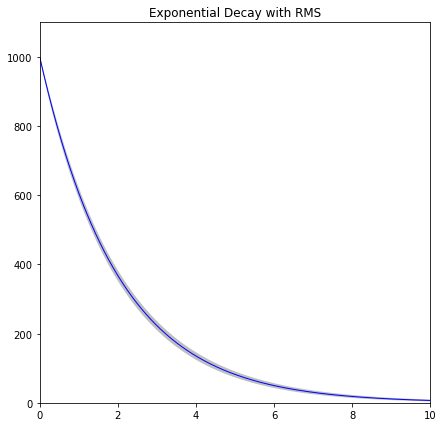

In [26]:
# make an instance of the rms_exp function we can call.
rms = rms_exp(1000, 0.5, time_range)

# make the lower and upper bounds
upper = x_decay + rms
lower = x_decay - rms

fig, ax = plt.subplots(figsize=(7, 7))
ax.set(ylim=(0, 1100), xlim=(0, time_range[-1]), 
       title='Exponential Decay with RMS')

ax.plot(time_range, x_decay, 'b', linewidth=1.0)
ax.fill_between(time_range, upper, lower, facecolor='grey', alpha=0.5);

## Gillespie Algorithm

Here I implement a version of Gillespie's algorithm.

In [28]:
class Gillespie:
    
    def __init__(self, X, C, delta_X, H):
        self.X = np.asarray(X, dtype=int)
        self.C = np.asarray(C)
        self.delta_X = np.asarray(delta_X, dtype=int)
        self.H = H

    @staticmethod
    def calc_av(X, H, C):
        """Calculate the Av value.
        The number of available permutations multiplied be the rates."""
        collisions = np.array([h(X) for h in H])
        return collisions * C
    
    @staticmethod
    def calc_tau(a0, rv):
        """Calculate the Tau value, which is the probable length of time
        before any given simulated reaction occurs."""
        return (1 / a0) * np.log(1 / rv)
    
    @staticmethod
    def calc_mu(av, a0, rv):
        """Calculate the mu value.
        
        :param Av_vals:
            The possible reaction permutations * their rates. Given
            as a numpy array.
        :param Av_sum:
            The sum of the `Av_vals` array. This sum is used in
            multiple places, so it is not calculated within this
            function.
        :param random_value:
            A randomly generated value between zero and one.
        :returns mu:
            The index corresponding to the reaction that should be
            simulated.
            
        Essentially we generate blocks of value on a number line
        from zero to one. A random number determines where on this
        line a reaction "occurs".
            [================================================]
            0.0                  *                          1.0
                                  A random point.
                                  
        We cast the possible reactions to this scale by multiplying
        the random value by the sum of Av values. Such casting is
        done by chunks.
            [================================================]
            [=Chunk 1=][======Chunk 2======][=====Chunk 3====]
            
        The sums of these chunks are examined, and when the sum is 
        found to be greater than the randomly cast point defined above, 
        the corresponding reaction is simulated.
        
        ..warning::
            A different random value should be used for `calc_mu()` and
            `calc_tau()`.
        """
        return np.argwhere(np.cumsum(av) > (rv * a0)).flatten()[0]
    
    def simulate(self, max_iter=1000, max_time=1000):
        """Runs a stochastic simulation based on the input provided."""
        curr_time = 0
        curr_iter = 0
        
        t_out = np.empty((max_iter))
        x_out = np.empty((max_iter, self.X.shape[0]))
        
        t_out[0] = curr_time
        x_out[0] = self.X.copy()
        
        while (curr_iter < max_iter) and (curr_time < max_time):
            av = self.calc_av(self.X, self.H, self.C)
            # print(av)
            a0 = np.sum(av)
            # print(a0)
            rv1, rv2 = rng.random(2)
            tau = self.calc_tau(a0, rv1)
            # print(tau)
            mu = self.calc_mu(av, a0, rv2)
            self.X += self.delta_X[mu]
            curr_time += tau
            t_out[curr_iter] = curr_time
            x_out[curr_iter] = self.X
            curr_iter += 1
                        
        return t_out, x_out

Now for the test, can we simulate an exponential decay process?

In [40]:
def h(x): return x[0]

In [30]:
%%time
# Measure the execution time of this cell.

# A dictionary of parameters for ease of use.
exp_decay_params = dict(
    X=[1000],
    C=[0.5],
    delta_X=[[-1]],
    H=[lambda x: x[0]]
)

gill = Gillespie(**exp_decay_params)
times, x_vals = gill.simulate()

Wall time: 39 ms


Now to plot the output, and compare it to the analytical result.

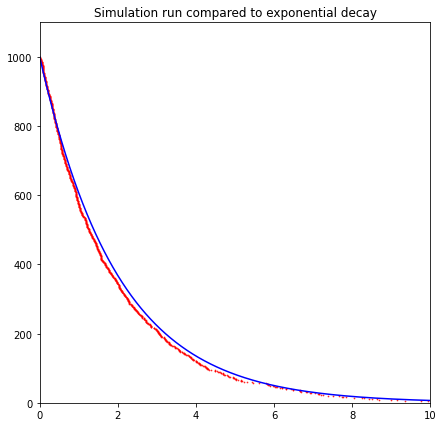

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(
    ylim=(0, 1100), 
    xlim=(0, time_range[-1]), 
    title='Simulation run compared to exponential decay')

ax.plot(time_range, x_decay, 'b', linewidth=1.5)
ax.scatter(times, x_vals, marker=".", s=2., alpha=0.8, color = 'r');

We can run and plot hundreds of runs:

In [33]:
%%time
exp_runs = [Gillespie(**exp_decay_params).simulate() for i in range(200)]

Wall time: 6.76 s


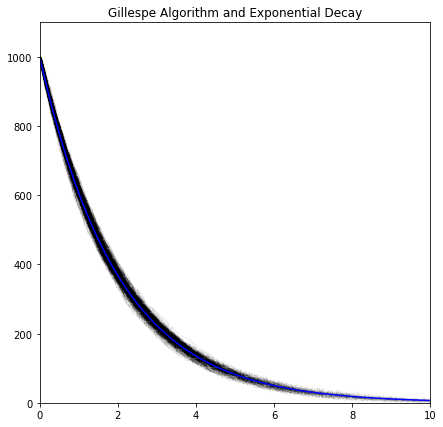

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(ylim=(0, 1100), xlim=(0, 10), title='Gillespe Algorithm and Exponential Decay')
ax.plot(time_range, x_decay, 'b', linewidth=1.5)
for run in exp_runs:
    t, x = run
    ax.scatter(t, x, marker=".", s=.1, alpha=0.1, color='k')

## Self-equilibrating Reactions

In [41]:
self_eq_params = dict(
    X=[3000],
    C=[5, 0.005],
    delta_X=[[1], [-2]],
    H=[
        lambda x: x[0], 
        lambda x: x[0] * (x[0] - 1) / 2,
      ]
)

In [43]:
self_eq_params

{'X': [3000],
 'C': [5, 0.005],
 'delta_X': [[1], [-2]],
 'H': [<function __main__.<lambda>(x)>, <function __main__.<lambda>(x)>]}

In [42]:
%%time

gill = Gillespie(**self_eq_params)
times, x_vals = gill.simulate(100000)

Wall time: 3.48 s


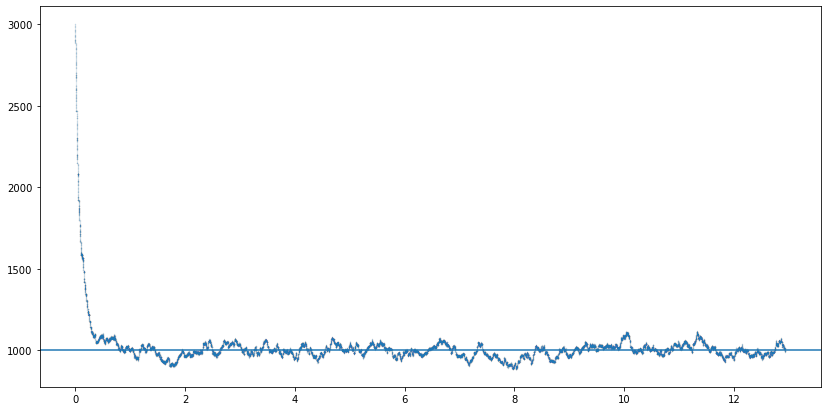

In [44]:
fig, ax = plt.subplots(figsize=(14, 7))
for x in x_vals.T:
    ax.scatter(times, x, marker=".", s=.1, alpha=0.1)
plt.axhline(y=1000)

## Lotka Reaction

Originally developed to model predator-prey interactions.

In [45]:
lotka_params = dict(
    X=[1000, 1000],
    C=[10, 0.01, 10],
    delta_X=[[1, 0], [-1, 1], [0, -1]],
    H=[
        lambda x: x[0], 
        lambda x: x[0] * x[1],
        lambda x: x[1]
      ]
)

In [48]:
x_vals.transpose()

array([[ 999., 1000.,  999., ...,  714.,  713.,  712.],
       [1001., 1001., 1002., ..., 1280., 1281., 1282.]])

In [49]:
x_vals.T

array([[ 999., 1000.,  999., ...,  714.,  713.,  712.],
       [1001., 1001., 1002., ..., 1280., 1281., 1282.]])

In [50]:
for x in x_vals.T:
    print(x.shape)
    break

(90000,)


In [51]:
for x in x_vals:
    print(x.shape)
    break

(2,)


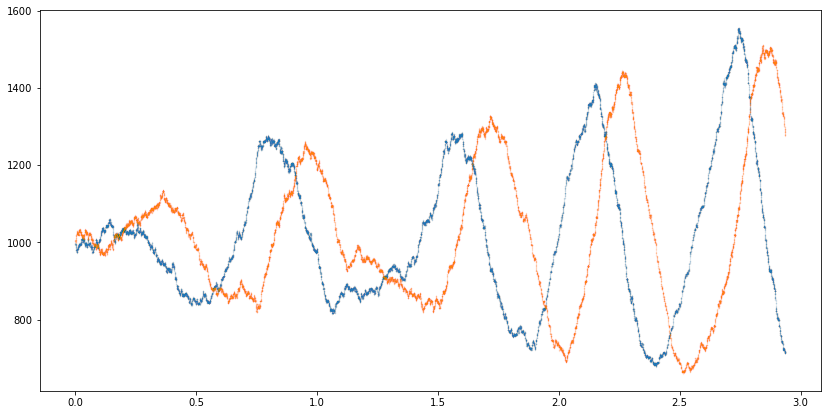

In [46]:
gill = Gillespie(**lotka_params)
times, x_vals = gill.simulate(90000)

fig, ax = plt.subplots(figsize=(14, 7))
for x in x_vals.T:
    ax.scatter(times, x, marker=".", s=.1, alpha=0.1)